<img src="http://bigdataexperience.org/BX/wp-content/uploads/2016/05/BX-FULL.png" width="200" height="200" alt="Big Data Experience Center, King Mongkut's University of Technology Thonburi">

# <center>CPE378 Machine Learning</center>
# <center>Lecture 05-2 - Text Classification</center>
---

# 1. Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
df = pd.read_pickle('Data/consumer_complaint_dataset.data', compression='gzip')
df.head()

,topic,input
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...
4,"Credit reporting, credit repair services, or o...",I have several accounts that the balance is in...


In [2]:
df.shape

(492255, 2)

In [3]:
df

,topic,input
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...
4,"Credit reporting, credit repair services, or o...",I have several accounts that the balance is in...
...,...,...
492250,Consumer Loan,I was on automatic payment for my car loan. In...
492251,Debt collection,I recieved a collections call from an unknown ...
492252,Mortgage,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who..."
492253,Mortgage,I can not get from chase who services my mortg...


In [5]:
# ดูการกระจายตัวของเรื่อง
pd.crosstab(df.topic, columns='Count')\
  .sort_values(by='Count', ascending=False)

col_0,Count
topic,
"Credit reporting, credit repair services, or other personal consumer reports",145090
Debt collection,106946
Mortgage,61581
Credit card or prepaid card,32144
Credit reporting,31588
Student loan,25083
Checking or savings account,19153
Credit card,18838
Bank account or service,14885


# 2. Label grouping / cleaning

- Group "Credit reporting" into "Credit reporting, credit repair services, or other personal consumer reports".
- Group "Credit card"/"Prepaid card" into "Credit card or prepaid card".
- Group "Payday loan" into "Payday loan, title loan, or personal loan".
- Group "Virtual currency"/"Money transfers" into "Money transfer, virtual currency, or money service".
- Remove "Other financial service"

In [6]:
# ทำการ Grouping
df.loc[df['topic'] == 'Credit reporting', 'topic'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['topic'] == 'Credit card', 'topic'] = 'Credit card or prepaid card'
df.loc[df['topic'] == 'Prepaid card', 'topic'] = 'Credit card or prepaid card'
df.loc[df['topic'] == 'Payday loan', 'topic'] = 'Payday loan, title loan, or personal loan'
df.loc[df['topic'] == 'Virtual currency', 'topic'] = 'Money transfer, virtual currency, or money service'
df.loc[df['topic'] == 'Money transfers', 'topic'] = 'Money transfer, virtual currency, or money service'
df = df[df['topic'] != 'Other financial service']

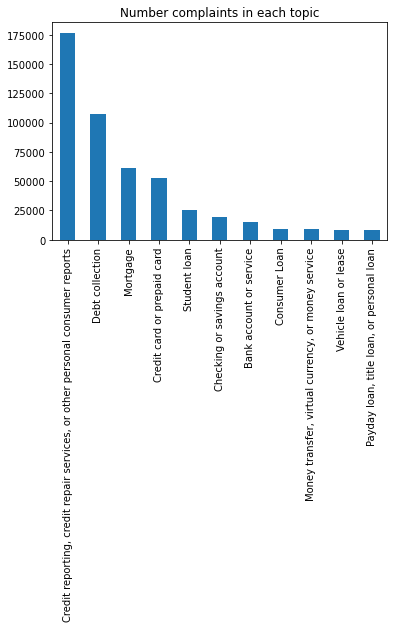

In [7]:
# กราฟแสดงการกระจายตัว (Grouping ตัวกลุ่มเล็ก ๆ ไปแล้ว ไม่งั้นเวลาทำ Classification ถ้ากลุ่มเล็ก ๆ อยู่มันจะโดน bias โดนกลุ่มใหญ่ ๆ เสมอ)
df['topic']\
  .value_counts()\
  .sort_values(ascending=False)\
  .plot(kind='bar',
        title='Number complaints in each topic')
plt.show()

In [8]:
# function print เฉย ๆ ดู text
def print_plot(index):
    example = df[df.index == index][['input', 'topic']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Topic:', example[1])
        
print_plot(10)

XXXX is reporting incorrectly to Equifax and XXXX an account balance of {$2300.00} on the XXXX partial account number XXXX. ( Please see pages 12 and 13 of the attached credit report ). This account is over 7 years old and therefore should not be on my credit report. This incorrect reporting is harming my credit score and is a Fair Credit Reporting Act ( F.C.R.A. ) violation.
Topic: Credit reporting, credit repair services, or other personal consumer reports


## Steps:
1. Convert all text to lower case.
2. Replace REPLACE_BY_SPACE_RE symbols by space in text.
3. Remove symbols that are in BAD_SYMBOLS_RE from text.
4. Remove “x” in text.
5. Remove stop words.
6. Remove digits in text.

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:

import re

# แทนที่ /(){}\[\]\|@,; ด้วย space
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# เอาสัญลักษณ์ออก
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

# เอา stopwords ออก
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['input'] = df['input'].apply(clean_text)

# Remove groups of numerical sequences with whitespace
df['input'] = df['input'].str.replace('\d+', '')

<ipython-input-12-ebafeb852390>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input'] = df['input'].apply(clean_text)
<ipython-input-12-ebafeb852390>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['input'] = df['input'].str.replace('\d+', '')
<ipython-input-12-ebafeb852390>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input'] = df['input'].str.replace('\d+', '')


In [13]:
print_plot(10)

reporting incorrectly equifa account balance  partial account number please see pages   attached credit report account  years old therefore credit report incorrect reporting harming credit score fair credit reporting act fcra violation
Topic: Credit reporting, credit repair services, or other personal consumer reports


In [15]:
df['input']

0         transworld systems inc trying collect debt min...
1         would like request suppression following items...
2         past  weeks receiving ecessive amounts telepho...
3         filed cfpb  listed accounts deleted stating ac...
4         several accounts balance incorrect couple limi...
                                ...                        
492250    automatic payment car loan fine print supposed...
492251    recieved collections call unknown company morn...
492252     contacted branch manager # gateway funding le...
492253    get chase services mortgage owns original loan...
492254    made payment citi credit card  using citi prep...
Name: input, Length: 491963, dtype: object

    df['input'] เป็น text หมดเลย เมื่อจะมาทำ Classification ต้องแปลงแต่ละตัวให้กลายเป็น Vector ก่อน 
    การแปลงให้กลายเป็น Vector ที่จะมาใช้งาน ก็จะมีการนับว่าเอกสารมีคำนี้เกิดขึ้นกี่ครั้ง(Term frequency: TF) 

In [17]:
# ทำ model
from sklearn.feature_extraction.text import TfidfVectorizer

# แปลงเป็น feature โดย feature ใช้ Tf-idf (Term Frequency – Inverse Document Frequency) ซึ่งเป็น feature ของตัว text 
vectorizer = TfidfVectorizer(max_features=20000) # 20000 คือ 20000 Columns

# แปลงเป็น matrix
tfidf_matrix = vectorizer.fit_transform(df['input'])

In [22]:
tfidf_matrix

<491963x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 28419397 stored elements in Compressed Sparse Row format>

    จะเป็น sparse matrix ขนาด 491963 คูณกับ 20000 จะมีทั้งหมด 28419397 ตัว 
    โดยถ้าอยากรู้แต่ละตัวตรงนี้ว่าเป็นยังไง สามารถทำ..(ด้านล่าง)

In [19]:
# ทำ decoding ซึ่งเป็นตัวที่มา map ว่าตำแหน่งนี้มีคำว่าอะไร
import numpy as np
decoding = np.array(vectorizer.get_feature_names())

In [29]:
np.where(tfidf_matrix[10].todense()) 

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], dtype=int64),
 array([  161,   288,  1329,  1604,  4156,  6390,  6687,  6800,  8069,
         8891,  8893, 11898, 12103, 12503, 12581, 13064, 14855, 14870,
        15738, 15865, 17800, 19270, 19921], dtype=int64))

In [30]:
decoding[np.where(np.array(tfidf_matrix[10].todense())[0] != 0)]

array(['account', 'act', 'attached', 'balance', 'credit', 'equifa',
       'fair', 'fcra', 'harming', 'incorrect', 'incorrectly', 'number',
       'old', 'pages', 'partial', 'please', 'report', 'reporting',
       'score', 'see', 'therefore', 'violation', 'years'], dtype='<U69')

In [31]:
print_plot(10)

reporting incorrectly equifa account balance  partial account number please see pages   attached credit report account  years old therefore credit report incorrect reporting harming credit score fair credit reporting act fcra violation
Topic: Credit reporting, credit repair services, or other personal consumer reports


# 3. Feature selection

In [32]:
# แปลง output ให้เป็น dummies
Y = pd.get_dummies(df['topic']).values

In [33]:
Y.shape

(491963, 11)

In [34]:
# เลือกตัวแปรที่สำคัญ
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10) # percentile = 10 เอามา 10%
selector.fit(tfidf_matrix, df['topic'])

SelectPercentile()

In [35]:
# เลือกตัว X มา
X = selector.transform(tfidf_matrix).toarray()

In [36]:
X.shape

(491963, 2000)

    จาก 20000 เหลือ 2000 Columns

In [39]:
decoding[selector.get_support()]

array(['aadvantage', 'able', 'abusive', ..., 'years', 'yelling', 'zelle'],
      dtype='<U69')

In [40]:
# สร้าง LabelEncoder ของตัว Y เพราะอยากรู้ว่าแต่ละอันตรงนี้มี Label ที่เท่าไร
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y = encoder.fit_transform(df['topic'])

In [41]:
Y

array([5, 4, 5, ..., 7, 7, 3])

# 4. Hold out sampling

In [43]:
# แยกข้อมูลเป็น train กับ test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['topic'], test_size=0.3) #test_size=0.3 คือ 30%

    เมื่อแยกข้อมูลเป็น train กับ test แล้วก็ใช้ Model โดยในนี้อ. เอามาให้ดู 3 อัน

# 5. Naive Bayes

In [44]:
%%time
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

Wall time: 15 s


GaussianNB()

In [45]:
%%time
score_train = model.score(X_train, y_train)

Wall time: 2min 8s


In [46]:
%%time
score_test = model.score(X_test, y_test)

Wall time: 46.9 s


In [47]:
print("\nTrain set score:", score_train)
print("Test set score:", score_test)


Train set score: 0.39370277663238223
Test set score: 0.3887349328201966


    เมื่อเอา Train set score และ Test set score มาเปรียบเทียบกัน 
    จะเห็นว่ายังไม่ค่อยดีเท่าไร

# 6. SVM

    อ.บอกว่าจริง ๆ แล้ว SVM ต้องไปปรับค่า c และอื่น ๆ อีกนะ แต่อันนี้ยังไม่ได้ปรับ

In [48]:
from sklearn.svm import LinearSVC
model = LinearSVC(class_weight='balanced')
model.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [49]:
res = model.predict(X_test)

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=res, y_true=y_test))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.47      0.44      0.45      4499
                                                 Checking or savings account       0.57      0.67      0.62      5830
                                                               Consumer Loan       0.34      0.32      0.33      2918
                                                 Credit card or prepaid card       0.77      0.81      0.79     15697
Credit reporting, credit repair services, or other personal consumer reports       0.91      0.81      0.86     52661
                                                             Debt collection       0.82      0.80      0.81     31856
                          Money transfer, virtual currency, or money service       0.67      0.81      0.73      2852
                                                       

In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred=res, y_true=y_test)

0.7951405592557711

accuracy ที่ได้คือ 79%

# 7. Random Forest

In [52]:
%%time
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

Wall time: 7min 20s


RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [53]:
res = model.predict(X_test)
print(classification_report(y_pred=res, y_true=y_test))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.62      0.31      0.41      4499
                                                 Checking or savings account       0.58      0.66      0.62      5830
                                                               Consumer Loan       0.53      0.15      0.23      2918
                                                 Credit card or prepaid card       0.77      0.80      0.78     15697
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.93      0.89     52661
                                                             Debt collection       0.83      0.83      0.83     31856
                          Money transfer, virtual currency, or money service       0.80      0.68      0.74      2852
                                                       

accuracy ที่ได้คือ 82% 

    จากการทำ model ของ SVM และ Random Forest ในค่า f1-score ของบาง topic (เช่น Mortgage) SVM ก็มากกว่า Random Forest 
    และ topic บางอัน (เช่น Credit reporting, credit repair services, or other personal consumer reports Random Forest) 
    ก็มากกว่า SVM

---